In [263]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn 
import torch.optim as optim

from sklearn.model_selection import train_test_split
from sklearn.metrics import * 
from tqdm import tqdm 

import warnings
warnings.filterwarnings("ignore")

In [264]:
def RUL_metric(y_valid, y_pred, threshold=10):

    error = y_valid.reshape(-1) - y_pred.reshape(-1)
    per = np.where(error<=threshold, 1, 0)
    
    return sum(per) / len(per)

In [265]:
# sns.set()

In [266]:
path = "data/Battery_RUL.csv"

In [267]:
data = pd.read_csv(path)

In [268]:
data.head()

,Cycle_Index,Discharge Time (s),Decrement 3.6-3.4V (s),Max. Voltage Dischar. (V),Min. Voltage Charg. (V),Time at 4.15V (s),Time constant current (s),Charging time (s),RUL
0,1.0,2595.30,1151.488500,3.670,3.211,5460.001,6755.01,10777.82,1112
1,2.0,7408.64,1172.512500,4.246,3.220,5508.992,6762.02,10500.35,1111
2,3.0,7393.76,1112.992000,4.249,3.224,5508.993,6762.02,10420.38,1110
3,4.0,7385.50,1080.320667,4.250,3.225,5502.016,6762.02,10322.81,1109
4,6.0,65022.75,29813.487000,4.290,3.398,5480.992,53213.54,56699.65,1107


In [269]:
data.shape

(15064, 9)

In [270]:
# 다음 컬럼들은 RUL에 관계가 없기 때문에 제거한다.
data=data.drop(['Cycle_Index','Discharge Time (s)', 'Decrement 3.6-3.4V (s)', 'Time constant current (s)','Charging time (s)'],axis=1)

In [271]:
data.head()

,Max. Voltage Dischar. (V),Min. Voltage Charg. (V),Time at 4.15V (s),RUL
0,3.670,3.211,5460.001,1112
1,4.246,3.220,5508.992,1111
2,4.249,3.224,5508.993,1110
3,4.250,3.225,5502.016,1109
4,4.290,3.398,5480.992,1107


## Modeling and Predections

In [287]:
class NeuralNet(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(NeuralNet, self).__init__()
        self.l1 = nn.Linear(input_size, hidden_size)
        self.l2 = nn.Linear(hidden_size, hidden_size//2)
        self.l3 = nn.Linear(hidden_size//2, hidden_size//2)
        self.l4 = nn.Linear(hidden_size//2, num_classes)
        self.act = nn.ELU()

    def forward(self, x):
        out = self.act(self.l1(x))
        out = self.act(self.l2(out))
        out = self.act(self.l3(out))
        out = self.l4(out)
        return out

In [288]:
data = data[data['RUL']!=0]

X = data.drop(['RUL'], axis=1)
y = data['RUL']

In [289]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=2023, shuffle =True)
X_val, X_test, y_val, y_test = train_test_split(X_val, y_val, test_size=0.2, random_state=2023, shuffle =True)

In [290]:
class Pipeline:
    def __init__(self, scalar):
        self.scalar = scalar
    
    def fit(self, X, y):
        X = self.scalar.fit_transform(X)
        return X, y.to_numpy(dtype=np.float32)
    
    def transform(self, X, y):
        X = self.scalar.transform(X)
        return X, y.to_numpy(dtype=np.float32)

In [291]:
from sklearn.preprocessing import RobustScaler, MinMaxScaler, StandardScaler
robust = RobustScaler()
pipeline = Pipeline(robust)

In [292]:
X_train_s, y_train_s = pipeline.fit(X_train, y_train)

X_val_s, y_val_s = pipeline.transform(X_val, y_val)
X_test_s, y_test_s = pipeline.transform(X_test, y_test)

In [293]:
X_train_s = torch.FloatTensor(X_train_s)
y_train_s = torch.FloatTensor(y_train_s).unsqueeze(-1)

X_val_s = torch.FloatTensor(X_val_s)
y_val_s = torch.FloatTensor(y_val_s).unsqueeze(-1)

X_test_s = torch.FloatTensor(X_test_s)
y_test_s = torch.FloatTensor(y_test_s).unsqueeze(-1)

In [294]:
X_train_s.shape, y_train_s.shape, X_val_s.shape, y_val_s.shape, X_test_s.shape, y_test_s.shape

(torch.Size([10535, 3]),
 torch.Size([10535, 1]),
 torch.Size([3612, 3]),
 torch.Size([3612, 1]),
 torch.Size([903, 3]),
 torch.Size([903, 1]))

In [295]:
input_size =  X_train_s.shape[1] #num of columns
hidden_size = 64
num_classes = 1

model = NeuralNet(input_size, hidden_size, num_classes)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.1, weight_decay=1e-5)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min')


Epoch : 1 / AVG train loss : 38.99163799240627
Test: 
 Avg loss: 113.367767, 

- RMSE: 639.91, - MAE: 554.35, - MAPE: 1.00,  - R2: -3.00,  - RUL_metric: 0.09, 

------------------------------------------------------------
Epoch : 2 / AVG train loss : 38.96376067869008
Test: 
 Avg loss: 110.278853, 

- RMSE: 631.13, - MAE: 546.07, - MAPE: 0.98,  - R2: -2.89,  - RUL_metric: 0.09, 

------------------------------------------------------------
Epoch : 3 / AVG train loss : 37.88474430469862
Test: 
 Avg loss: 101.415706, 

- RMSE: 605.24, - MAE: 524.10, - MAPE: 0.95,  - R2: -2.58,  - RUL_metric: 0.09, 

------------------------------------------------------------
Epoch : 4 / AVG train loss : 34.79570775984813
Test: 
 Avg loss: 81.758600, 

- RMSE: 543.43, - MAE: 473.22, - MAPE: 0.89,  - R2: -1.89,  - RUL_metric: 0.11, 

------------------------------------------------------------
Epoch : 5 / AVG train loss : 28.229241813004272
Test: 
 Avg loss: 53.628041, 

- RMSE: 440.12, - MAE: 377.99, - M

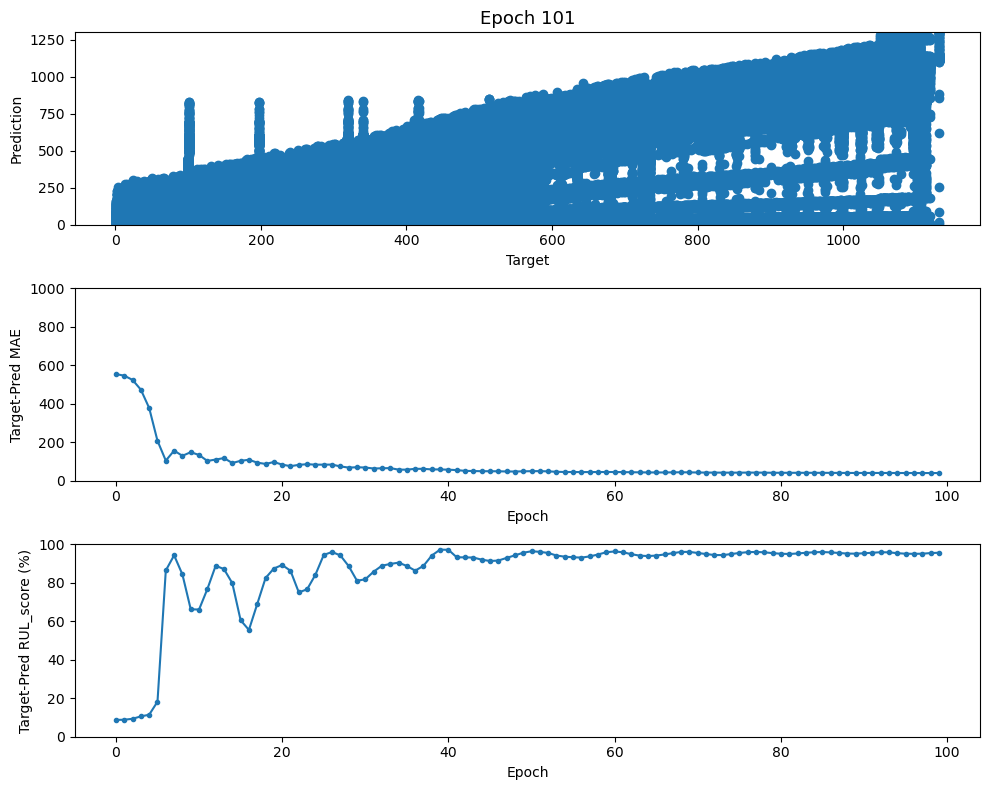

In [296]:
train_loss_list = []
test_loss_list = []
min_diff_dict = {}

targets_list = []
pred_list = []
epoch_list = []
MAE_list= []
RUL_score_list = []
best_MAE = np.inf
best_model = 0
# for epoch in tqdm(range(1, 101)):
for epoch in range(1, 101):
    size = len(X_train_s)
    optimizer.zero_grad()
    outputs = model(X_train_s)
    loss = criterion(outputs, y_train_s)
    loss.backward()
    optimizer.step()
    print(f'Epoch : {epoch} / AVG train loss : {loss.item()/size}')
    train_loss_list.append(loss.item()/size)
    
    with torch.no_grad():
        size = len(X_val_s)
        pred = model(X_val_s)
        test_loss = criterion(pred, y_val_s)
        
        test_loss_list.append(test_loss.item()/size)
        pred_np = pred.squeeze().tolist()
        target_np = y_val_s.squeeze().tolist()
        
        try:
            for i,j in zip(pred_np,target_np):
                pred_list.append(i)
                targets_list.append(j)
        except:
            pass
        
        pred = pred.detach().cpu().numpy()
        y = y_val_s.detach().cpu().numpy()
    
        RMSE = mean_squared_error(y, pred, squared=False)
        MAE = mean_absolute_error(y, pred)
        MAPE = mean_absolute_percentage_error(y, pred)
        R2 = r2_score(y, pred)
        RUL_score = RUL_metric(y, pred, threshold=100)
        msg = f"Test: \n Avg loss: {test_loss.item()/size:>8f}, \n"
        print(msg) 
        msg = f"- RMSE: {(RMSE):>0.2f}, - MAE: {(MAE):>0.2f}, - MAPE: {(MAPE):>0.2f},  - R2: {(R2):>0.2f},  - RUL_metric: {(RUL_score):>0.2f}, \n"
        print(msg)
        print('---'*20)
        
        scheduler.step(test_loss)

    epoch_list.append(epoch)
    MAE_list.append(MAE)
    RUL_score_list.append(RUL_score*100)
    
    mean_MAE = np.mean(MAE_list)
    if mean_MAE < best_MAE:
        best_MAE = mean_MAE
        best_model = model
    
plt.figure(figsize=(10,8))
plt.subplot(3,1,1)
plt.scatter(targets_list, pred_list)
plt.xlabel('Target', fontsize=10)
plt.ylabel('Prediction', fontsize=10)
plt.ylim(0, 1300)
plt.title(f"Epoch {epoch+1}", fontsize=13)

plt.subplot(3,1,2)
# plt.scatter(epoch_list, MAE_list)
plt.plot(MAE_list, label='RUL_score', marker = '.')
plt.ylim(0, 1000)
plt.xlabel('Epoch')
plt.ylabel('Target-Pred MAE')

# PLOT Difference
plt.subplot(3,1,3)
# plt.scatter(epoch_list, RUL_score_list)
plt.plot(RUL_score_list, label='RUL_score', marker = '.')
plt.ylim(0, 100)
plt.xlabel('Epoch')
plt.ylabel('Target-Pred RUL_score (%)')
# plt.scatter(epoch, test_loss)
plt.tight_layout()

plt.savefig(f'./result/training_{epoch}.png')
        

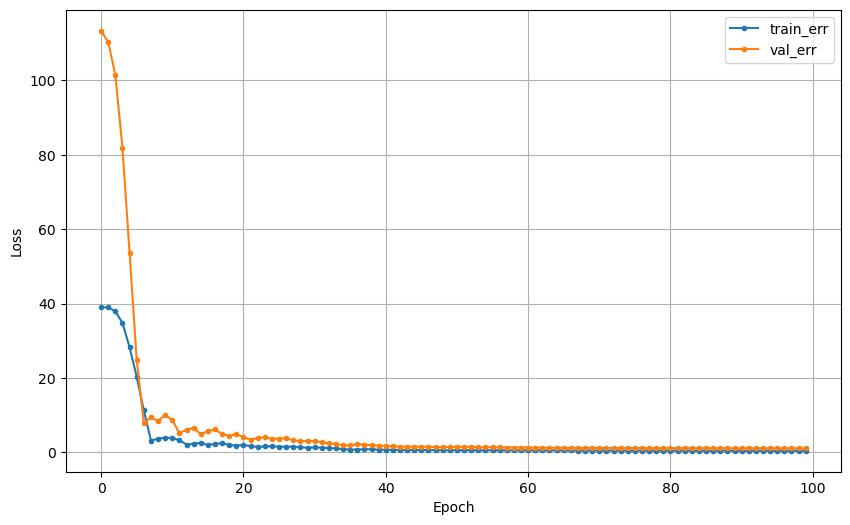

In [297]:
# 함수로 만들어서 사용합시다.
def dl_history_plot(train_loss_list, test_loss_list):
    plt.figure(figsize=(10,6))
    plt.plot(train_loss_list, label='train_err', marker = '.')
    plt.plot(test_loss_list, label='val_err', marker = '.')

    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend()
    plt.grid()
    plt.show()
    
dl_history_plot(train_loss_list, test_loss_list)

In [298]:
def visualization_result(y_val,pred, size=100):
  sns.lineplot(y_val[:size], label='valid train')
  sns.lineplot(pred.reshape(pred.shape[0],)[:size], label='pred')
  plt.legend(loc='upper right')
  plt.show()

In [299]:
pred = best_model(X_test_s)

In [300]:
pred = pred.detach().cpu().numpy()
X_test_s = y_test_s.detach().cpu().numpy()

In [301]:
from sklearn.metrics import * 

def RUL_metric(y_valid, y_pred, threshold=10):

    error = y_valid.reshape(-1) - y_pred.reshape(-1)
    per = np.where(error<=threshold, 1, 0)
    
    return sum(per) / len(per)

print(f'RMSE : {mean_squared_error(y_test_s, pred, squared=False)}')
print(f'MAE  : {mean_absolute_error(y_test_s, pred)}')
print(f'MAPE : {mean_absolute_percentage_error(y_test_s, pred)}')
print(f'R2 : {r2_score(y_test_s, pred)}')
print(f'RUL_metric : {RUL_metric(y_test_s, pred, threshold=100)}')

RMSE : 61.32408142089844
MAE  : 40.767242431640625
MAPE : 0.303305059671402
R2 : 0.9633687666914793
RUL_metric : 0.9501661129568106


In [348]:
def visualization_result(y_val,pred, size=100):
  pred = pred.reshape(pred.shape[0],)
  sns.lineplot(y_val[:size], label='actual RUL')
  sns.lineplot(pred[:size], label='pred RUL')
  plt.legend(ncols=2, ('actual RUL', 'pred RUL'))
  plt.show()

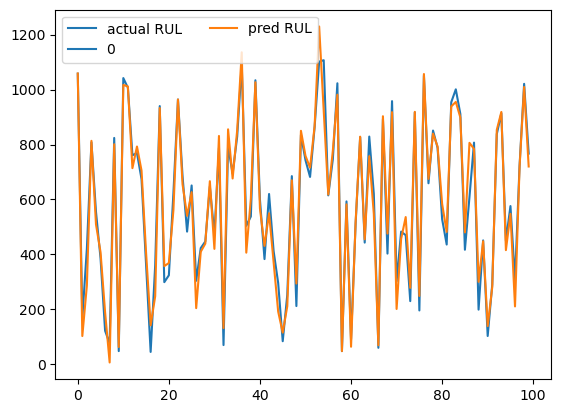

In [349]:
visualization_result(y_test_s,pred, size=100)

In [ ]:
'''
class NeuralNet(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(NeuralNet, self).__init__()
        self.l1 = nn.Linear(input_size, hidden_size)
        self.l2 = nn.Linear(hidden_size, num_classes)
        self.act = nn.ELU()

    def forward(self, x):
        out = self.l1(x)
        out = self.act(out)
        out = self.l2(out)
        return out

일 경우 
RMSE : 122.64473724365234
MAE  : 93.70903778076172
MAPE : 0.5671193599700928
R2 : 0.8534832507200503
RUL_metric : 0.8748615725359912


class NeuralNet(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(NeuralNet, self).__init__()
        self.l1 = nn.Linear(input_size, hidden_size)
        self.l2 = nn.Linear(hidden_size, hidden_size)
        self.l3 = nn.Linear(hidden_size, num_classes)
        self.act = nn.ELU()
        self.Drop = nn.Dropout(p=0.25)

    def forward(self, x):
        out = self.l1(x)
        out = self.act(out)
        out = self.l2(out)
        out = self.act(out)
        out = self.l3(out)
        return out

RMSE : 73.60551452636719
MAE  : 51.06753158569336
MAPE : 0.33087578415870667
R2 : 0.9472272048922442
RUL_metric : 0.9258028792912514

'''